## Ensemble learning and Random Forest


This is a notebook to learn about different optimization techniques. First libraries are loaded and a dataset is loaded. The data is prepared for the machine learning algorithms and splitted into a training set and a test set. Different classifiers are tried and evaluated. After that different ensemble methods are applied to improve the performance. The learning outcomes of this exercise are

1. understand the differences in methodologies 
2. apply these to your own dataset. Bring your own or choose one from  http://archive.ics.uci.edu/ml/index.php 


#### Solve the following
1. Review the code below briefly. What are the repeating parts?
    - model = Classifier(), model.fit, model.predict, evaluate
2. Run the code for a different dataset
    - can be any classification dataset
3. For every classifier assess possible overfit (implement code for this)
    - see learning curve
4. Implement a Naive Bayes classifier as well
    - see Naive Bayes
5. Explain the difference between RandomForest and Voting Classifier
    - Random forest is ensemble on decision trees based on bagging method which uses same classifier but different subsets of sample. Voting Classifier is a method which compares different classifiers. 
6. Explain the difference between hard and soft voting
    - Hard voting is where a model is selected from an ensemble to make the final prediction by a simple majority vote for accuracy.
    - Soft Voting can only be done when all your classifiers can calculate probabilities for the outcomes. Soft voting arrives at the best result by averaging out the probabilities calculated by individual algorithms
7. Explain the difference between bagging and stacking 
    - bagging: fit several independent models and “average” their predictions in order to obtain a model with a lower variance. Use the same classifier but changes subset of data to generate the several model. 
    - stacking: stacking trains different models based on different classifiers and combine them by training a meta-model. For instance use a logistic regression and a SVM as different classifiers, and a neural network as meta-mode   
8. Adjust the bagging classifier in such way that it uses another algorithm 
    - see code
9. Implement stacking 
    - see code
10. Implement gradient boosting
    - see code
11. What algorithm can you use for very big datasets, and why
    - if you can distribute the algorithm accross several servers it can speed up the process. This can be done if each predictor in the ensemble is independent from the other, like the case in bagging. 

12. What is the best strategy to find an optimal model for your chosen dataset
    - start simple, improve data quality , compare models, tweak configurations.
  
You can use any sources to find the answers. More information is to be found in the book, the presentation and the internet. The 11 questions and small assignments are a guideline to get familiar with the material. You are encouraged to explore more configurations.

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load and prepare Data

In [2]:
df = pd.read_pickle('../data/breast_cancer.pkl')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302.0,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517.0,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903.0,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301.0,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402.0,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
#fill X matrix en y vector
cols = [
        'texture_mean', 
        'area_mean', 
        'smoothness_mean', 
        'compactness_mean', 
        'concavity_mean',
        'concave points_mean', 
        'symmetry_mean', 
        'fractal_dimension_mean']
y = np.array(df['diagnosis'])
X = np.array(df[cols])
X.shape

(569, 8)

In [4]:
#normalize
from sklearn.preprocessing import StandardScaler

def normalize(X):
    scalar = StandardScaler()
    scalar = scalar.fit(X)
    X = scalar.transform(X)
    return X

X = normalize(X)

In [5]:
from sklearn.model_selection import train_test_split, ShuffleSplit

#split
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

#cross validation
cv = ShuffleSplit(n_splits=100, test_size=test_size, random_state=0)

---
# Try different classifiers

In [6]:
# function to evaluate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

def evaluate(y_test, y_pred, X_test, clf):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
      
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    input:
        model:pipeline object
        X_train, y_train: training data
        X_val, y_val: test data
    """
    train_errors, val_errors = [], []
    for m in range(30, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=1, label="training data")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="validation data")
    plt.legend(loc="upper right", fontsize=10)   
    plt.xlabel("Training set size", fontsize=10) 
    plt.ylabel("RMSE", fontsize=10)     
    # compare accuracy train versus test to access overfit 
    print(f'test  acc: {model.score(X_val, y_val)}')
    print(f'train acc: {model.score(X_train, y_train)}')



## Logistic

In [7]:
#train
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# evaluation
y_pred = lg.predict(X_test)
evaluate(y_test, y_pred, X_test, lg)

[[100   3]
 [ 10  58]]
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       103
         1.0       0.95      0.85      0.90        68

    accuracy                           0.92       171
   macro avg       0.93      0.91      0.92       171
weighted avg       0.93      0.92      0.92       171



test  acc: 0.9239766081871345
train acc: 0.9547738693467337


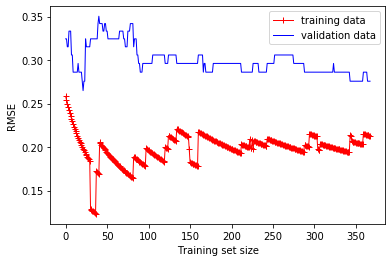

In [9]:
plot_learning_curves(lg, X_train, y_train, X_test, y_test)


## Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
y_pred = dt.predict(X_test)
evaluate(y_test, y_pred, X_test, dt)

[[95  8]
 [ 5 63]]
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       103
         1.0       0.89      0.93      0.91        68

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171



test  acc: 0.935672514619883
train acc: 1.0


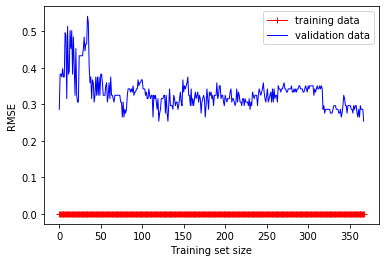

In [12]:
plot_learning_curves(dt, X_train, y_train, X_test, y_test)

## SVM 


In [13]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

[[101   2]
 [  8  60]]
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       103
         1.0       0.97      0.88      0.92        68

    accuracy                           0.94       171
   macro avg       0.95      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171

test  acc: 0.9415204678362573
train acc: 0.9723618090452262


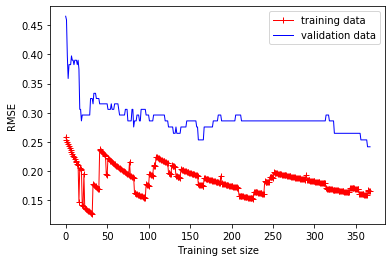

In [14]:
y_pred = svm.predict(X_test)
evaluate(y_test, y_pred, X_test, svm)
plot_learning_curves(svm, X_train, y_train, X_test, y_test)

## Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

[[95  8]
 [ 8 60]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       103
         1.0       0.88      0.88      0.88        68

    accuracy                           0.91       171
   macro avg       0.90      0.90      0.90       171
weighted avg       0.91      0.91      0.91       171

test  acc: 0.9064327485380117
train acc: 0.9271356783919598


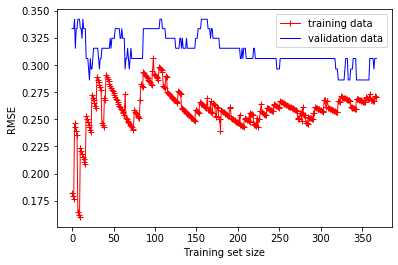

In [16]:
y_pred = gnb.predict(X_test)
evaluate(y_test, y_pred, X_test, gnb)
plot_learning_curves(gnb, X_train, y_train, X_test, y_test)

---
# Ensemble learning

In [17]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier

## Random Forest

In [18]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[[97  6]
 [ 6 62]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       103
         1.0       0.91      0.91      0.91        68

    accuracy                           0.93       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.93      0.93      0.93       171

test  acc: 0.9239766081871345
train acc: 0.9949748743718593


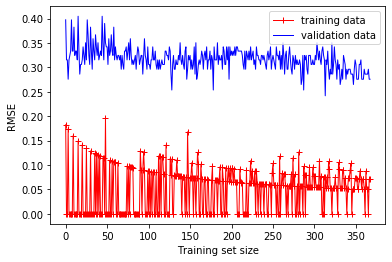

In [19]:
y_pred = rf.predict(X_test)
evaluate(y_test, y_pred, X_test, rf)
plot_learning_curves(rf, X_train, y_train, X_test, y_test)

## Bagging with Decicion Tree classifier

In [20]:
bg = BaggingClassifier(DecisionTreeClassifier(), max_features = 1.0, max_samples = 0.5) 
bg.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


[[95  8]
 [ 5 63]]
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       103
         1.0       0.89      0.93      0.91        68

    accuracy                           0.92       171
   macro avg       0.92      0.92      0.92       171
weighted avg       0.93      0.92      0.92       171

test  acc: 0.9473684210526315
train acc: 0.9824120603015075


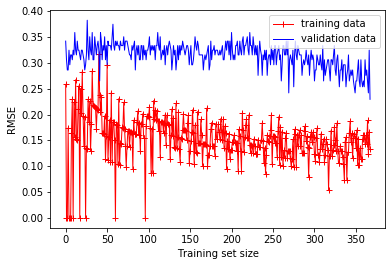

In [21]:
y_pred = bg.predict(X_test)
evaluate(y_test, y_pred, X_test, bg)
plot_learning_curves(bg, X_train, y_train, X_test, y_test)

# Boosting

In [22]:
adb = AdaBoostClassifier(LogisticRegression(), n_estimators = 10, learning_rate = 1)
adb.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='auto',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=1, n_estimators=10, random_state=None)

[[101   2]
 [ 10  58]]
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       103
         1.0       0.97      0.85      0.91        68

    accuracy                           0.93       171
   macro avg       0.94      0.92      0.93       171
weighted avg       0.93      0.93      0.93       171

test  acc: 0.9298245614035088
train acc: 0.9472361809045227


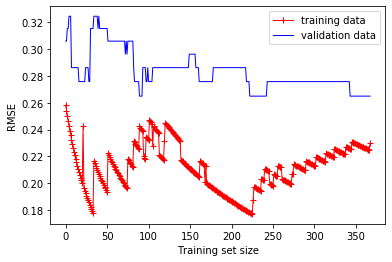

In [23]:
y_pred = adb.predict(X_test)
evaluate(y_test, y_pred, X_test, adb)
plot_learning_curves(adb, X_train, y_train, X_test, y_test)

# Stacking

In [24]:
from sklearn.ensemble import StackingClassifier
estimators = [('dt', dt), ('lg',lg), ('svm', svm), ('gnb', gnb)]
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_train, y_train)

StackingClassifier(cv=None,
                   estimators=[('dt',
                                DecisionTreeClassifier(ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                     

[[99  4]
 [ 7 61]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       103
         1.0       0.94      0.90      0.92        68

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

test  acc: 0.935672514619883
train acc: 0.9773869346733668


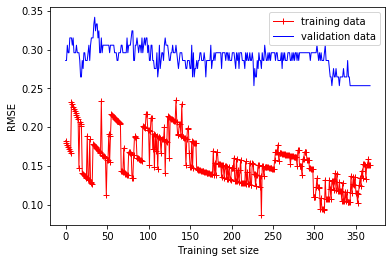

In [25]:
y_pred = sclf.predict(X_test)
evaluate(y_test, y_pred, X_test, sclf)
plot_learning_curves(sclf, X_train, y_train, X_test, y_test)

# Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
grad = GradientBoostingClassifier(random_state=0)
grad.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

[[94  9]
 [ 5 63]]
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       103
         1.0       0.88      0.93      0.90        68

    accuracy                           0.92       171
   macro avg       0.91      0.92      0.92       171
weighted avg       0.92      0.92      0.92       171

test  acc: 0.9181286549707602
train acc: 1.0


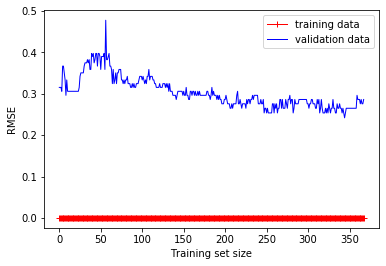

In [27]:
y_pred = grad.predict(X_test)
evaluate(y_test, y_pred, X_test, grad)
plot_learning_curves(grad, X_train, y_train, X_test, y_test)

# Voting classifier

In [28]:
evc = VotingClassifier(estimators = [('dt', dt), ('lg',lg), ('svm', svm)], voting = 'hard')
evc.fit(X_train, y_train)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
   

[[100   3]
 [  8  60]]
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       103
         1.0       0.95      0.88      0.92        68

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

test  acc: 0.935672514619883
train acc: 0.9723618090452262


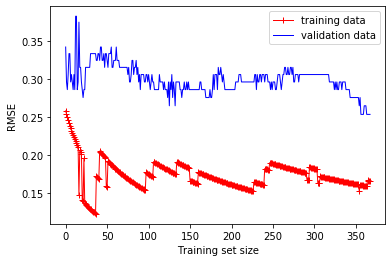

In [29]:
y_pred = evc.predict(X_test)
evaluate(y_test, y_pred, X_test, evc)
plot_learning_curves(evc, X_train, y_train, X_test, y_test)